# Group Classification (ZenML)

Train the `GroupClassifier` on real preprocessed time-group data:
- Load preprocessed time groups from .npy files in the data folder
- Train the `GroupClassifier` via a ZenML pipeline with Optuna hyperparameter tuning
- Reload artifacts and render evaluation plots (confusion matrices, ROC curves, etc.)


In [1]:
from pioneerml.zenml import utils as zenml_utils

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_client = zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)
print(f"ZenML ready with stack: {zenml_client.active_stack_model.name}")


Using ZenML repository root: /home/jack/python_projects/pioneerML
Ensure this is the top-level of your repo (.zen must live here).
ZenML ready with stack: default


In [2]:
import os
import optuna
from pathlib import Path
from pioneerml.zenml import load_step_output
from pioneerml.zenml.pipelines.training import group_classification_optuna_pipeline
from pioneerml.optuna import OptunaStudyManager
from pioneerml.data import CLASS_NAMES, NUM_GROUP_CLASSES

# Set up Optuna storage
optuna_manager = OptunaStudyManager(
    project_root=PROJECT_ROOT,
    study_name="group_classifier",
)
optuna_storage = optuna_manager.resolve_storage()
print(f"Using Optuna storage: {optuna_storage}")


Using Optuna storage: sqlite:////home/jack/python_projects/pioneerML/.optuna/group_classifier_01_01_2026.db


In [3]:
# Run (or reuse) the Optuna + training pipeline

hits_pattern = str(Path(PROJECT_ROOT) / "data" / "hits_batch_*.npy")
info_pattern = str(Path(PROJECT_ROOT) / "data" / "group_info_batch_*.npy")

run = group_classification_optuna_pipeline.with_options(enable_cache=False)(
    build_datamodule_params={
        "hits_pattern": hits_pattern,
        "info_pattern": info_pattern,
        "max_files": 20,
        "limit_groups": 1_000_000,
        "min_hits": 2,
        "min_hits_per_label": 2,
        "batch_size": 64,
        "val_split": 0.15,
        "seed": 42,
    },
    run_hparam_search_params={
        'n_trials': 1,  # set >0 to add trials; 0 to reuse previous best if storage has it
        'max_epochs': 1,
        'limit_train_batches': 0.8,
        'limit_val_batches': 1.0,
        'storage': optuna_storage,
        'study_name': 'group_classifier',
    },
    train_best_model_params={
        'max_epochs': 1,
        'early_stopping': True,
        'early_stopping_patience': 4,
    },
)
print(f"Run name: {run.name}")
print(f"Run status: {run.status}")


Initiating a new run for the pipeline: group_classification_optuna_pipeline.
Caching is disabled by default for group_classification_optuna_pipeline.
Using user: default
Using stack: default
  artifact_store: default
  deployer: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step build_group_classification_datamodule has started.


[build_group_classification_datamodule] Auto-detected num_workers: 11 (from 12 CPU cores, using cores-1)
[build_group_classification_datamodule] Starting to load data from: hits=/home/jack/python_projects/pioneerML/data/hits_batch_*.npy, info=/home/jack/python_projects/pioneerML/data/group_info_batch_*.npy
[build_group_classification_datamodule] Limiting to 11 files (from 11 total files found, max_files=20)
[build_group_classification_datamodule] Limiting to 11 files (from 11 total files found, max_files=20)
[build_group_classification_datamodule] Loaded 109817 groups from 11 file pairs
[build_group_classification_datamodule] Loaded 109817 groups. Building datamodule...
[build_group_classification_datamodule] Calling setup(stage='fit')...
[build_group_classification_datamodule] Setup complete. Train: 93345, Val: 16472


Step build_group_classification_datamodule has finished in 23.728s.
Step run_group_classification_hparam_search has started.


[run_group_classification_hparam_search] Using GPU: NVIDIA GeForce RTX 5070
[run_group_classification_hparam_search] CUDA devices: 1
[run_group_classification_hparam_search] Enabled Tensor Core optimization (medium precision)
[run_group_classification_hparam_search] Dataset sizes - Train: 93345, Val: 16472
[run_group_classification_hparam_search] Starting Optuna search with 1 trials, 1 epochs per trial...
[I 2026-01-02 07:04:08,624] Using an existing study with name 'group_classifier_01_01_2026' instead of creating a new one.
[run_group_classification_hparam_search] Starting Optuna study (storage=sqlite:////home/jack/python_projects/pioneerML/.optuna/group_classifier_01_01_2026.db, name=group_classifier_01_01_2026)...


  0%|          | 0/1 [00:00<?, ?it/s]

[run_group_classification_hparam_search] Trial 1/1 (cumulative 3/3) starting...
[run_group_classification_hparam_search] Trial 1 params: batch_size=128, hidden=128 (from 128), heads=4, num_blocks=3, dropout=0.1956, lr=0.002136, weight_decay=0.000012
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 1 training 1 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


[run_group_classification_hparam_search] Trial 1 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 1 completed with score: 0.991076
[run_group_classification_hparam_search] Optuna search complete! Best score: 0.991076
[run_group_classification_hparam_search] Best params: {'batch_size': 128, 'hidden': 128, 'heads': 4, 'num_blocks': 3, 'dropout': 0.1956153589905551, 'lr': 0.0021356974769316346, 'weight_decay': 1.1802536905148162e-05}


[I 2026-01-02 07:05:04,513] Trial 2 finished with value: 0.9910757541656494 and parameters: {'batch_size': 128, 'hidden': 128, 'heads': 4, 'num_blocks': 3, 'dropout': 0.1956153589905551, 'lr': 0.0021356974769316346, 'weight_decay': 1.1802536905148162e-05}. Best is trial 2 with value: 0.9910757541656494.
Step run_group_classification_hparam_search has finished in 1m46s.
Step train_best_group_classifier has started.


[train_best_group_classifier] Starting final model training...
[train_best_group_classifier] Dataset sizes - Train: 93345, Val: 16472
[train_best_group_classifier] Using GPU: NVIDIA GeForce RTX 5070
[train_best_group_classifier] CUDA devices: 1
[train_best_group_classifier] Enabled Tensor Core optimization (medium precision)
[train_best_group_classifier] Training configuration:
[train_best_group_classifier]   max_epochs: 1
[train_best_group_classifier]   early_stopping: True
[train_best_group_classifier]   early_stopping_patience: 4
[train_best_group_classifier] Starting training...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Metric val_loss improved. New best score: 0.038
`Trainer.fit` stopped: `max_epochs=1` reached.


[train_best_group_classifier] Training complete! Final epoch: 2


Step train_best_group_classifier has finished in 1m47s.
Step collect_group_classification_predictions has started.
Step collect_group_classification_predictions has finished in 1m10s.
Pipeline run has finished in 5m9s.
Run name: group_classification_optuna_pipeline-2026_01_02-12_02_53_414220
Run status: completed


In [4]:
trained_module = load_step_output(run, "train_best_group_classifier")
datamodule = load_step_output(run, "build_group_classification_datamodule")
predictions = load_step_output(run, "collect_group_classification_predictions", index=0)
targets = load_step_output(run, "collect_group_classification_predictions", index=1)
best_params = load_step_output(run, "run_group_classification_hparam_search")

if trained_module is None or datamodule is None:
    raise RuntimeError("Could not load artifacts from the optuna pipeline run.")

datamodule.setup(stage="fit")
trained_module.eval()
device = next(trained_module.parameters()).device
val_size = len(datamodule.val_dataset) if datamodule.val_dataset is not None else len(datamodule.train_dataset)
print(f"Loaded module on {device}; validation samples: {val_size}")

# Print best params without trial_history for cleaner output
best_params_display = {k: v for k, v in best_params.items() if k != "trial_history"} if isinstance(best_params, dict) else best_params
print("Best params from Optuna:", best_params_display)
print("Epochs actually run:", getattr(trained_module, "final_epochs_run", None))

Loaded module on cpu; validation samples: 16472
Best params from Optuna: {'batch_size': 128, 'hidden': 128, 'heads': 4, 'num_blocks': 3, 'dropout': 0.1956153589905551, 'lr': 0.0021356974769316346, 'weight_decay': 1.1802536905148162e-05, 'best_score': 0.9910757541656494, 'n_trials': 3} {'batch_size': 128, 'hidden': 128, 'heads': 4, 'num_blocks': 3, 'dropout': 0.1956153589905551, 'lr': 0.0021356974769316346, 'weight_decay': 1.1802536905148162e-05, 'best_score': 0.9910757541656494, 'n_trials': 3}
Epochs actually run: 2 2


In [5]:
# Class names for group classification
class_names = [CLASS_NAMES[i] for i in range(NUM_GROUP_CLASSES)]
print("Class names (index-aligned):", class_names)

Class names (index-aligned): ['pion', 'muon', 'mip'] ['pion', 'muon', 'mip']


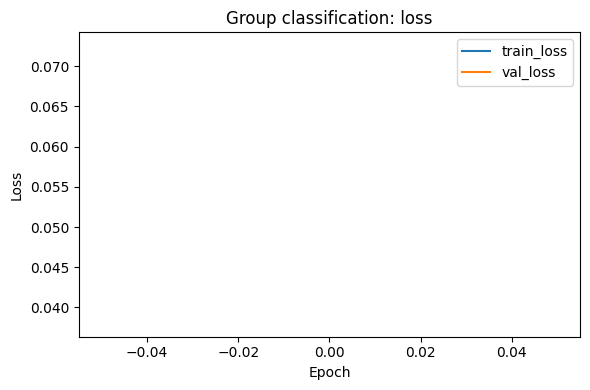

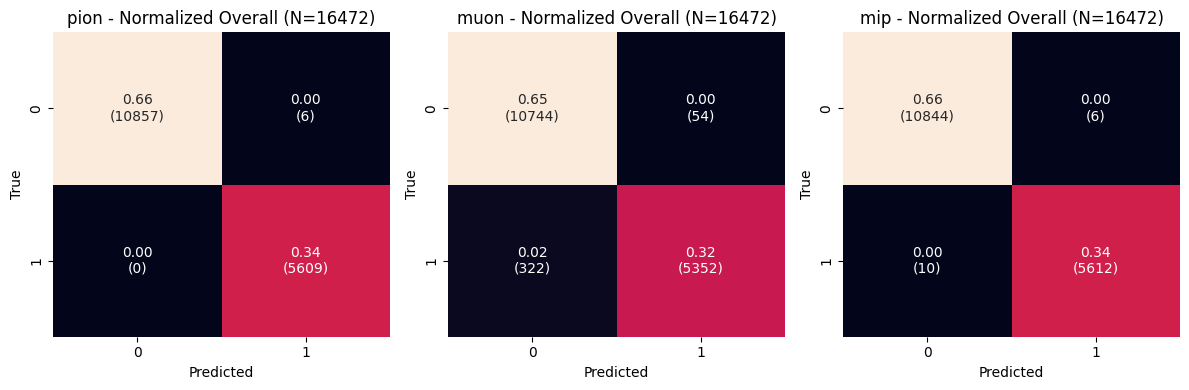

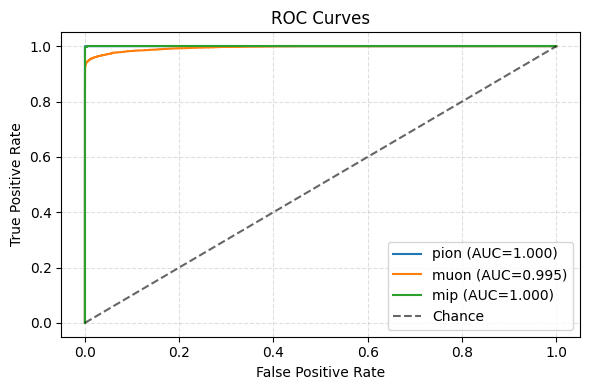

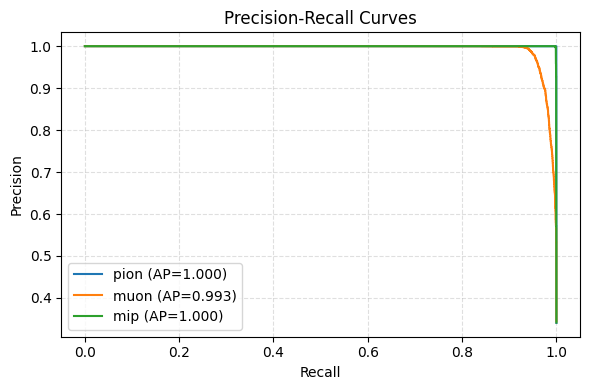

In [6]:
from pioneerml.evaluation.plots import (
    plot_loss_curves,
    plot_multilabel_confusion_matrix,
    plot_precision_recall_curves,
    plot_roc_curves,
)

plot_loss_curves(trained_module, title="Group classification: loss", show=True)
plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    threshold=0.5,
    normalize=True,
    show=True,
)
plot_roc_curves(predictions, targets, class_names=class_names, show=True)
plot_precision_recall_curves(predictions, targets, class_names=class_names, show=True)


## Save the Trained Model

Save the trained model and metadata for later use.


In [7]:
from pioneerml.metadata import TrainingMetadata, save_model_and_metadata, timestamp_now

# Build metadata and save model + metadata together
save_ts = timestamp_now()

meta = TrainingMetadata(
    model_type="GroupClassifier",
    timestamp=save_ts,
    run_name=run.name if 'run' in locals() else None,
    best_hyperparameters=best_params,
    best_score=best_params.get('best_score') if isinstance(best_params, dict) else None,
    n_trials=best_params.get('n_trials') if isinstance(best_params, dict) else None,
    training_config=getattr(trained_module, 'training_config', {}),
    epochs_run=getattr(trained_module, 'final_epochs_run', None),
    dataset_info={
        'train_size': len(datamodule.train_dataset) if datamodule.train_dataset else 0,
        'val_size': len(datamodule.val_dataset) if datamodule.val_dataset else 0,
        'num_classes': NUM_GROUP_CLASSES,
        'class_names': class_names,
    },
    model_architecture={
        'num_classes': NUM_GROUP_CLASSES,
        'hidden': best_params.get('hidden') if isinstance(best_params, dict) else None,
        'num_blocks': best_params.get('num_blocks') if isinstance(best_params, dict) else None,
        'dropout': best_params.get('dropout') if isinstance(best_params, dict) else None,
    },
    # Store link to Optuna DB instead of full history
    optuna_storage=optuna_storage,
    optuna_study_name=optuna_manager.study_name,
)

paths = save_model_and_metadata(
    model=trained_module.model,
    metadata=meta,
    state_dict_only=True,
)

print("Saved artifacts:")
for k, v in paths.items():
    print(f"  {k}: {v}")


Saved artifacts:
  dir: /home/jack/python_projects/pioneerML/trained_models/groupclassifier
  state_dict: /home/jack/python_projects/pioneerML/trained_models/groupclassifier/groupclassifier_20260102_120808_group_classification_optuna_pipeline-2026_01_02-12_02_53_414220_state_dict.pt
  metadata: /home/jack/python_projects/pioneerML/trained_models/groupclassifier/groupclassifier_20260102_120808_group_classification_optuna_pipeline-2026_01_02-12_02_53_414220_metadata.json
  full_checkpoint: /home/jack/python_projects/pioneerML/trained_models/groupclassifier/groupclassifier_20260102_120808_group_classification_optuna_pipeline-2026_01_02-12_02_53_414220_checkpoint.pt
